<a href="https://colab.research.google.com/github/Enrique720/Proyecto-BigData/blob/main/Proyecto_Opencv_Jeanlee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

In [ ]:
!pip install ray

In [3]:
import cv2
import random
from google.colab.patches import cv2_imshow

In [4]:
def horizontal_flip(img, flag=True):
    if flag: return cv2.flip(img, 1)
    else: return img


In [5]:
def vertical_flip(img, flag=True):
    if flag: return cv2.flip(img, 0)
    else: return img


In [6]:
def rotation(img, angle):
    angle = int(random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img


In [7]:
def resize(img, width, height):
  dim = (width, height)
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  return resized
 

## Augmentated data

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import os
import os.path
from os import path
import shutil
import ray
import time

In [10]:
num_workers = 4
ray.init(num_cpus=num_workers, ignore_reinit_error=True)

{'metrics_export_port': 62597,
 'node_id': '00fe4c0bdccf51bb3d1d7c91fa8b444e1712c60cf6b035b812e7637b',
 'node_ip_address': '172.28.0.2',
 'object_store_address': '/tmp/ray/session_2021-12-09_02-29-40_331462_62/sockets/plasma_store',
 'raylet_ip_address': '172.28.0.2',
 'raylet_socket_name': '/tmp/ray/session_2021-12-09_02-29-40_331462_62/sockets/raylet',
 'redis_address': '172.28.0.2:6379',
 'session_dir': '/tmp/ray/session_2021-12-09_02-29-40_331462_62',
 'webui_url': None}

In [11]:
n_final = 1000

base_folder = '/content/drive/MyDrive/BIG_DATA/RAW_FISH_DATASET/'
final_folder = '/content/drive/MyDrive/BIG_DATA/OPENCV/'

def cleanDirs():
  if path.isdir(final_folder):
    shutil.rmtree(final_folder)
  os.mkdir(final_folder)

species_names = next(os.walk(base_folder))[1]


In [12]:

def aumentedBySpecies(specie):
  #print("Processing specie:", specie)
  raw_folder = base_folder + specie + '/'
  out_folder = final_folder + specie + '/'
  os.mkdir(out_folder)

  files = next(os.walk(raw_folder))[2]
  proportion = n_final // len(files)
  
  for cont, img_name in enumerate(files):
    f_name = os.path.splitext(img_name)[0]
    img = cv2.imread(raw_folder + img_name)
    img = resize(img, 590, 445)
    for i in range(proportion):
      if (i/2): img = horizontal_flip(img)
      if (i%2): img = vertical_flip(img)
      img = rotation(img, 30+i+cont)
      cv2.imwrite(out_folder+f_name+'_'+str(i)+'.png',img)


In [13]:

@ray.remote
def aumentedBySpecies_ray(specie):
  #print("Processing specie:", specie)
  raw_folder = base_folder + specie + '/'
  out_folder = final_folder + specie + '/'
  os.mkdir(out_folder)

  files = next(os.walk(raw_folder))[2]
  proportion = n_final // len(files)
  
  for cont, img_name in enumerate(files):
    f_name = os.path.splitext(img_name)[0]
    img = cv2.imread(raw_folder + img_name)
    img = resize(img, 590, 445)
    for i in range(proportion):
      if (i/2): img = horizontal_flip(img)
      if (i%2): img = vertical_flip(img)
      img = rotation(img, 30+i+cont)
      cv2.imwrite(out_folder+f_name+'_'+str(i)+'.png',img)


In [34]:
# Clear species directories
cleanDirs()

### Without Ray

In [14]:
print("Processing without Ray\n")
cleanDirs()

start = time.time()
for specie in species_names:
  aumentedBySpecies(specie)
end = time.time()

print("\nElapsed time:", end - start, "(segs)")


Processing without Ray


Elapsed time: 622.0127532482147 (segs)


### With Ray

In [15]:
print("Processing with Ray\n")
cleanDirs()

start = time.time()
ray.get([aumentedBySpecies_ray.remote(specie) for specie in species_names])
end = time.time()

print("\nElapsed time:", end - start, "(segs)")


Processing with Ray


Elapsed time: 235.04383206367493 (segs)


# CNN Model

## Read data

In [43]:
import numpy as np # linear algebra
import pandas as pd
from pathlib import Path

In [47]:
dataset_path = Path(r'/content/drive/MyDrive/BIG_DATA/OPENCV')

file_path = list(dataset_path.glob(r'**/*.png'))

# create labels from the folder name
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [48]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)

df = pd.concat([file_path, labels], axis=1)

df.columns = ['image', 'label']

df.head()

,image,label
0,/content/drive/MyDrive/BIG_DATA/OPENCV/Sea Bas...,Sea Bass
1,/content/drive/MyDrive/BIG_DATA/OPENCV/Sea Bas...,Sea Bass
2,/content/drive/MyDrive/BIG_DATA/OPENCV/Sea Bas...,Sea Bass
3,/content/drive/MyDrive/BIG_DATA/OPENCV/Sea Bas...,Sea Bass
4,/content/drive/MyDrive/BIG_DATA/OPENCV/Sea Bas...,Sea Bass


In [49]:
df.label.value_counts()

Horse Mackerel        1000
Trout                 1000
Shrimp                1000
Sea Bass              1000
Red Sea Bream         1000
Red Mullet            1000
Gilt Head Bream       1000
Black Sea Sprat       1000
Striped Red Mullet    1000
Name: label, dtype: int64

## Create train, test and validation dataset

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [52]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (5040, 2)
Shape of test data (2700, 2)
Shape of validation data (1260, 2)


In [53]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

In [54]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

Found 5040 validated image filenames belonging to 9 classes.
Found 2700 validated image filenames belonging to 9 classes.
Found 1260 validated image filenames belonging to 9 classes.


Define the model

In [55]:
input_shape = (200, 200, 3)


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation='softmax')
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

In [56]:
from tensorflow.keras.optimizers import Adam

## Train the model

In [57]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
start = time.time()
history = model.fit(train, validation_data=val, epochs=20, callbacks=callback)
end = time.time()
print("\nElapsed time:", end - start, "(segs)")

Epoch 1/20
158/158 [==============================] - 681s 4s/step - loss: 1.9125 - accuracy: 0.2159 - val_loss: 1.5782 - val_accuracy: 0.3111
Epoch 2/20
158/158 [==============================] - 665s 4s/step - loss: 1.6139 - accuracy: 0.3028 - val_loss: 1.5279 - val_accuracy: 0.3111
Epoch 3/20
158/158 [==============================] - 665s 4s/step - loss: 1.5272 - accuracy: 0.3292 - val_loss: 1.4325 - val_accuracy: 0.3929
Epoch 4/20
158/158 [==============================] - 673s 4s/step - loss: 1.4661 - accuracy: 0.3617 - val_loss: 1.3513 - val_accuracy: 0.4381
Epoch 5/20
158/158 [==============================] - 673s 4s/step - loss: 1.3099 - accuracy: 0.4508 - val_loss: 1.3934 - val_accuracy: 0.4167
Epoch 6/20
158/158 [==============================] - 675s 4s/step - loss: 1.1630 - accuracy: 0.5165 - val_loss: 1.0085 - val_accuracy: 0.5810
Epoch 7/20
158/158 [==============================] - 678s 4s/step - loss: 1.0442 - accuracy: 0.5625 - val_loss: 0.9214 - val_accuracy: 0.6381

Tiempo: 1h
(3658.069s)

In [ ]:
model.save('model-opencv.h5')

## Verify model's performance

In [58]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

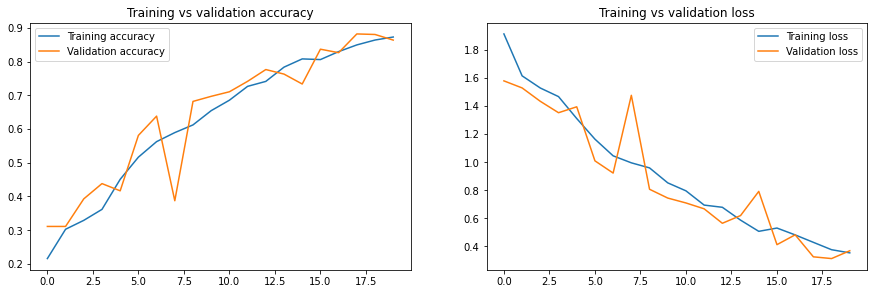

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()